# GCN for DAVIS 2016

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train a simple GCN network as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler

from torch_geometric.data import DataLoader

from pg_datasets.davis_2016 import DAVIS2016
from pg_networks.gcn import GCN
from pg_solvers.solver import Solver
from pg_utils.vis_utils import plot_img_with_contour_and_translation, plot_translations, plot_loss

from Combination_OSVOS_contour.final_prediction import compute_combo_img, plot_all

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths & Constants

In [4]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'#'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

SKIP_SEQUENCES = []

SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
                 'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
                 'paragliding', 'rhino', 'scooter-gray', 'swing']

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

BATCH_SIZE = 32
LAYER = 9
K = 32
EPOCHS_WO_AVEGRAD = 100

## Train and Val Dataset

In [5]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, EPOCHS_WO_AVEGRAD,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                  train=True)

In [6]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, EPOCHS_WO_AVEGRAD,
                SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                train=False)

In [7]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

Train size: 1355
Val size: 1061


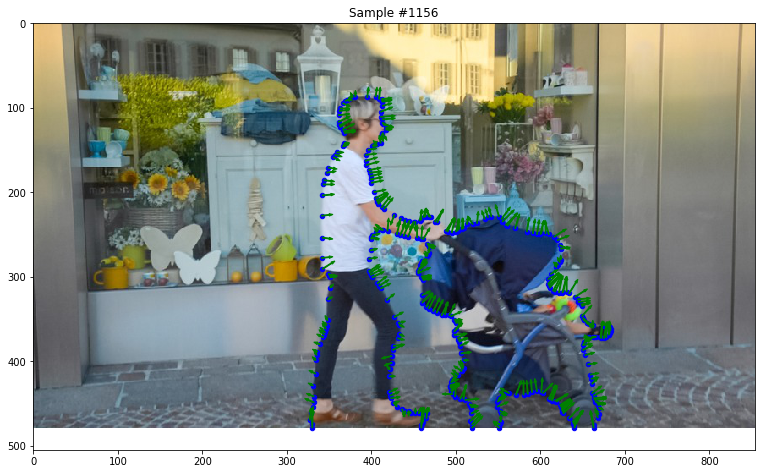

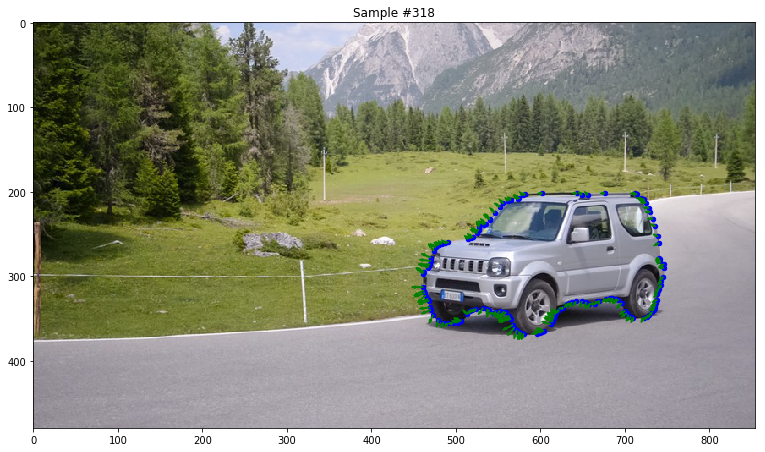

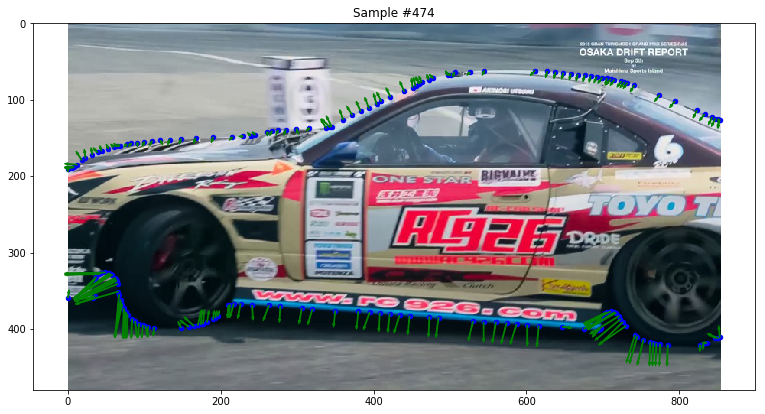

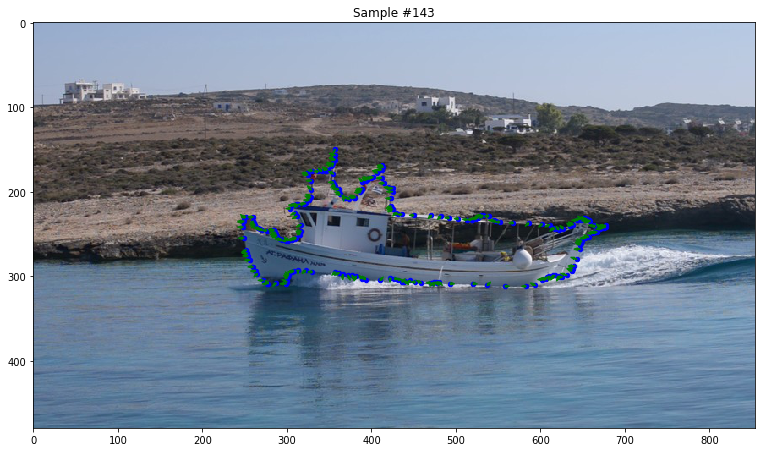

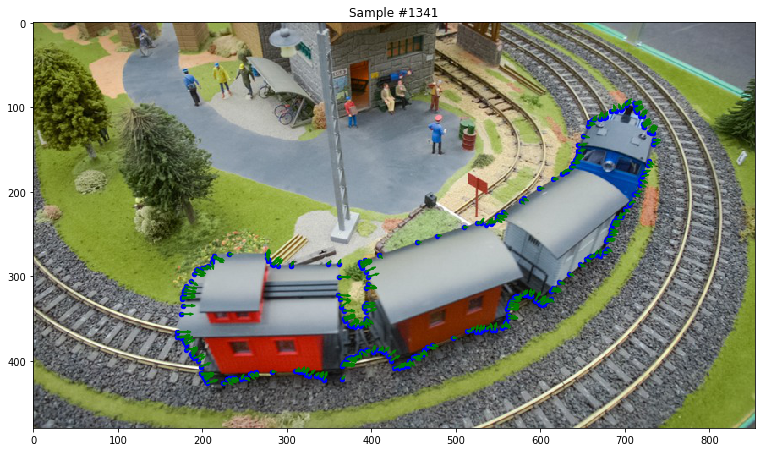

In [8]:
num_to_display = 5

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(num_to_display*15,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    data = train[rand_i]
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_img_with_contour_and_translation(data.img, data.contour, data.y)

## Simple GCN

In [9]:
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 1024)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
)


### Overfit

In [11]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])

overfit_solver = Solver(optim_args={"lr": 1e-6})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=20, log_nth=100, verbose=True)

START TRAIN.
[Epoch 1/20] trainloss: 91.96101 - val_loss: 8.03825
	L1 Loss: translation: 7.223134962411237 rounded: 7.219313259555778
	L2 Loss: translation: 91.96100549363963 rounded: 92.07529688434343
	L1 Loss:   Magnitude: 9.343663554942914 Angle: 61.89147752459403
	  -> rounded: Magnitude: 9.349336654085967 Angle: 61.934856364710605
	L2 Loss:   Magnitude: 142.31907001406344 Angle: 100.34355591853027
	  -> rounded: Magnitude: 142.5241032701426 Angle: 100.76760722259793
[Epoch 2/20] trainloss: 6.28338 - val_loss: 7.36172
	L1 Loss: translation: 1.8955898437588856 rounded: 1.880460886531423
	L2 Loss: translation: 6.283381045765232 rounded: 6.357516467012895
	L1 Loss:   Magnitude: 1.5235753137067654 Angle: 53.85274878173617
	  -> rounded: Magnitude: 1.5346639922325733 Angle: 52.74927539552647
	L2 Loss:   Magnitude: 5.19874396329777 Angle: 77.21248149716054
	  -> rounded: Magnitude: 5.287972130803099 Angle: 78.64674272370671
[Epoch 3/20] trainloss: 5.59779 - val_loss: 6.74741
	L1 Loss: tr

In [13]:
plot_loss(overfit_solver) # New function for all new losses

AttributeError: 'Solver' object has no attribute 'train_loss_epoch_history'

<Figure size 720x504 with 0 Axes>

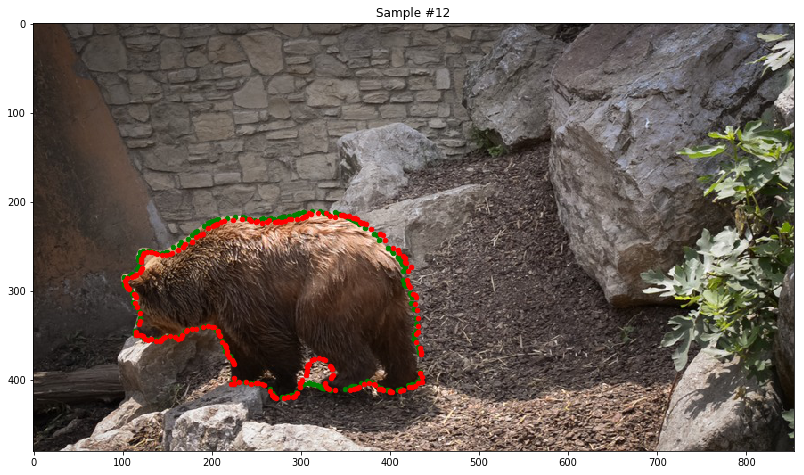

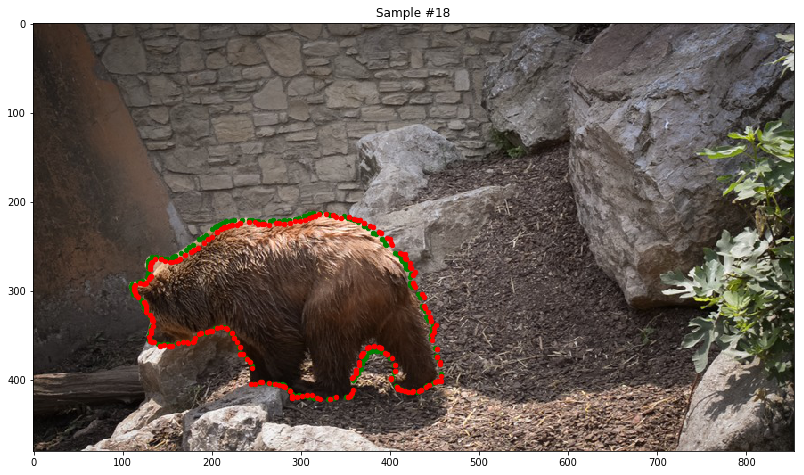

In [15]:
model.cpu()
model.double()
model.eval()
num_to_display = 2

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*15,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, num_val)
    data = train[rand_i]
    
    with torch.no_grad():
        translation_pred = model(data)
        
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred)    

In [54]:
#Show test run for one example image
original_img = 'DAVIS_2016/DAVIS/JPEGImages/480p/bear/00001.png'
OSVOS_img = cv2.imread('OSVOS_PyTorch/models/Results/bear/00001.png')
old_contour = train[0].contour
translation_pred = model(train[0])
print(type(old_contour), old_contour.type, type(translation_pred), translation_pred.type)
predicted_contour = old_contour.add(translation_predtype(torch.DoubleTensor))

final_prediction = compute_combo_img(predicted_contour, OSVOS_img)
plot_all(predicted_contour, OSVOS_img)

<class 'torch.Tensor'> <built-in method type of Tensor object at 0x7fc8e96c91b0> <class 'torch.Tensor'> <built-in method type of Tensor object at 0x7fc8e96a53f0>


RuntimeError: expected backend CPU and dtype Double but got backend CPU and dtype Float

### Train

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": 1e-6})

solver.train(model, train_loader, val_loader,
             num_epochs=50, log_nth=10, verbose=True)

In [ ]:
plot_loss(solver)

### Display trained outputs

In [ ]:
model.cpu()
model.double()
model.eval()
num_to_display = 5

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*15,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(val))
    data = val[rand_i]
    
    with torch.no_grad():
        translation_pred = model(data)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred) 